In [2]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
import pickle
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import ray
from ray.tune import ExperimentAnalysis
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, SVMEvaluator, LREvaluator



device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_analysis = ExperimentAnalysis(experiment_checkpoint_path='/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09')

In [28]:
all_analysis.dataframe(metric='performance_dp', mode='max')

,kernel_gdp,performance_dp,performance,loss,conditional_loss,debias_loss,adv_loss,time_this_iter_s,should_checkpoint,done,...,config/dataset_name,config/debias,config/debias_ratio,config/debias_temp,config/drop_prob,config/hidden_dim,config/lr,config/sens_name,config/tau,logdir
0,0.000864,0.635726,0.636590,0.001561,0.001270,0.000049,0.0,190.763416,True,False,...,celeba,True,5.895037,0.024837,0.219337,200,0.000210,gender,0.050515,/data/qf31/ray_results/celeba/gender/search_mo...
1,0.017313,0.548410,0.565723,2.238300,2.196279,0.013459,0.0,269.539187,True,False,...,celeba,True,3.122249,0.017248,0.425590,240,0.000074,gender,0.198912,/data/qf31/ray_results/celeba/gender/search_mo...
2,0.024581,0.556115,0.580696,0.862880,0.861164,0.000236,0.0,239.281687,True,False,...,celeba,True,7.256937,0.030740,0.116299,220,0.000246,gender,0.171210,/data/qf31/ray_results/celeba/gender/search_mo...
3,0.019591,0.594488,0.614079,1.696126,1.695093,0.000143,0.0,191.449155,True,False,...,celeba,True,7.230731,0.015912,0.490736,200,0.000155,gender,0.199594,/data/qf31/ray_results/celeba/gender/search_mo...
4,0.005140,0.638946,0.644086,0.217433,0.167327,0.010301,0.0,273.299906,True,False,...,celeba,True,4.863918,0.021152,0.177331,200,0.000213,gender,0.067259,/data/qf31/ray_results/celeba/gender/search_mo...
5,0.005643,0.640695,0.646338,0.482876,0.480141,0.000357,0.0,239.646708,True,False,...,celeba,True,7.656160,0.031590,0.496908,200,0.000052,gender,0.144628,/data/qf31/ray_results/celeba/gender/search_mo...
6,0.010038,0.570678,0.580716,0.522608,0.464597,0.008514,0.0,268.660330,True,False,...,celeba,True,6.813876,0.018929,0.348476,240,0.000160,gender,0.116665,/data/qf31/ray_results/celeba/gender/search_mo...
7,0.007375,0.586850,0.594224,0.074216,0.072252,0.000265,0.0,243.099121,True,False,...,celeba,True,7.412683,0.021477,0.299075,200,0.000477,gender,0.105780,/data/qf31/ray_results/celeba/gender/search_mo...
8,0.016056,0.622772,0.638828,0.002692,0.002218,0.000066,0.0,243.877056,True,False,...,celeba,True,7.157213,0.021295,0.319233,220,0.000263,gender,0.051112,/data/qf31/ray_results/celeba/gender/search_mo...
9,0.009872,0.597347,0.607219,0.182613,0.181705,0.000143,0.0,240.559627,True,False,...,celeba,True,6.329416,0.032772,0.243589,220,0.000124,gender,0.131997,/data/qf31/ray_results/celeba/gender/search_mo...


In [29]:
all_analysis.dataframe(metric='performance_dp', mode='max').iloc[0].logdir

'/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09/search_model_c744e_00002_2_batch_size=1024,cond_temp=0.0045809,debias_ratio=5.895,debias_temp=0.024837,drop_prob=0.21934,hidden_di_2022-05-29_21-54-12'

In [30]:
all_analysis.dataframe(metric='kernel_gdp', mode='min').iloc[0].logdir

'/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09/search_model_c744e_00002_2_batch_size=1024,cond_temp=0.0045809,debias_ratio=5.895,debias_temp=0.024837,drop_prob=0.21934,hidden_di_2022-05-29_21-54-12'

{'dataset_name': 'celeba', 'sens_name': 'gender', 'conditional': True, 'debias': True, 'adversarial': False, 'batch_size': 1024, 'hidden_dim': 200, 'drop_prob': 0.21933711406450526, 'cond_temp': 0.004580936862279113, 'debias_temp': 0.024837335160686837, 'debias_ratio': 5.895037428868658, 'lr': 0.00020992489648128816, 'tau': 0.050515329052622834}


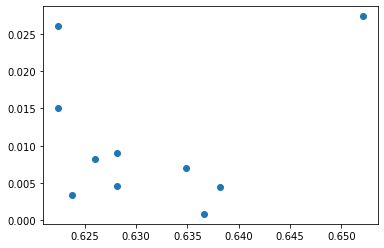

In [40]:
p = '/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09/search_model_c744e_00002_2_batch_size=1024,cond_temp=0.0045809,debias_ratio=5.895,debias_temp=0.024837,drop_prob=0.21934,hidden_di_2022-05-29_21-54-12/checkpoint_000010/'
model_state, optimizer_state,config = torch.load(os.path.join(p, 'checkpoint'))
plt.scatter(config['performance_list'], config['kernel_gdp_list'])
print(config['config'])

/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09/search_model_c744e_00016_16_batch_size=1024,cond_temp=0.0048447,debias_ratio=4.5441,debias_temp=0.019297,drop_prob=0.32952,hidden__2022-05-30_00-20-13/checkpoint_000010/


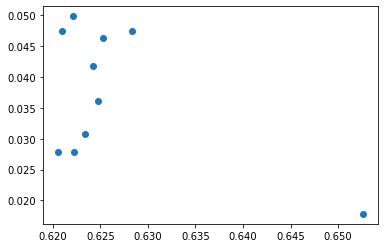

In [31]:
best_performance_trial = all_analysis.get_best_trial(metric='performance', mode='max', scope='all')
print(best_performance_trial.checkpoint.value)
model_state, optimizer_state,config = torch.load(os.path.join(best_performance_trial.checkpoint.value, 'checkpoint'))
plt.scatter(config['performance_list'], config['kernel_gdp_list'])

/data/qf31/ray_results/celeba/gender/search_model_2022-05-29_21-54-09/search_model_c744e_00017_17_batch_size=768,cond_temp=0.0048498,debias_ratio=7.6562,debias_temp=0.03159,drop_prob=0.49691,hidden_di_2022-05-30_00-21-10/checkpoint_000010/


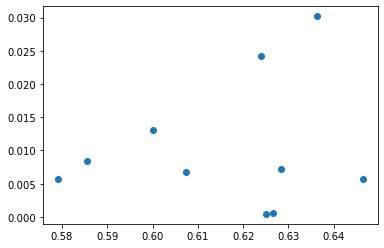

In [32]:
best_performance_trial = all_analysis.get_best_trial(metric='performance_dp', mode='max', scope='all')
print(best_performance_trial.checkpoint.value)
model_state, optimizer_state,config = torch.load(os.path.join(best_performance_trial.checkpoint.value, 'checkpoint'))
plt.scatter(config['performance_list'], config['kernel_gdp_list'])

In [17]:
best_performance_trial = all_analysis.get_best_trial(metric='kernel_gdp', mode='min', scope='all')
model_state, optimizer_state,config = torch.load(os.path.join(best_performance_trial.checkpoint.value, 'checkpoint'))
plt.scatter(config['performance_list'], config['hist_gdp_list'])

Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: 'NoneType' object has no attribute 'checkpoint'

In [75]:
torch.save(config,'./adult_age_ray_config_result')